COMP4211 - Assignment 1

In [455]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Part 1: Data Exploration and Preparation

#### Q1: Dataset Overview

In [456]:
df = pd.read_csv("data.csv")

In [457]:
#Overview of dataset (first 5 rows)

df.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,reg_target,class_target
0,male,22.0,1,0,A/5 21171,NaN,S,Lower Class,"Braund, Mr. Owen Harris",7.2500,0
1,female,38.0,1,0,PC 17599,C85,C,Upper Class,"Cumings, Mrs. John Bradley (Florence Briggs Th...",71.2833,1
2,female,26.0,0,0,STON/O2. 3101282,NaN,S,Lower Class,"Heikkinen, Miss. Laina",7.9250,1
3,female,35.0,1,0,113803,C123,S,Upper Class,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",53.1000,1
4,male,35.0,0,0,373450,NaN,S,Lower Class,"Allen, Mr. William Henry",8.0500,0


In [458]:
# Number of rows and columns in dataset

print(f"Shape of dataframe: {df.shape}")

Shape of dataframe: (891, 11)


In [459]:
# Size of dataset (total number of elements in the DataFrame)

print(f"The size of the dataset: {df.size}")

The size of the dataset: 9801


In [460]:
# Missing values for each column

missing_values = df.isna().sum()
missing_values

c1                0
c2              177
c3                0
c4                0
c5                0
c6              687
c7                2
c8                0
c9                0
reg_target        0
class_target      0
dtype: int64

In [461]:
# Proportion of missing values

total_values = df.shape[0]


proportion_missing = missing_values / total_values

proportion_missing

c1              0.000000
c2              0.198653
c3              0.000000
c4              0.000000
c5              0.000000
c6              0.771044
c7              0.002245
c8              0.000000
c9              0.000000
reg_target      0.000000
class_target    0.000000
dtype: float64

## Q2: Feature Distribution

Fasit: 

c1 = Categorical --> binary
c2 = Numerical --> discrete/continous depending on interpretation
c3 = numerical --> discrete
c4 = numerical --> discrete
c5 = categorical --> nominal
c6 = categorical --> nominal
c7 = categorical --> nominal
c8 = categorical --> ordinal
c9 = categorical --> nominal
reg_target = Numerical --> continous
class_target = Categorical --> binary???

['c1', 'c5', 'c6', 'c7', 'c8', 'c9']

#### Numerical Features

In [462]:
# Column data types

df.dtypes

c1               object
c2              float64
c3                int64
c4                int64
c5               object
c6               object
c7               object
c8               object
c9               object
reg_target      float64
class_target      int64
dtype: object

In [463]:
### Make this one include only the feature names, not the data.

numerical_features = df.select_dtypes(include=["int64", "float64"])
new_numerical_features = df.drop(columns=["class_target"])
print(numerical_features) # dropping class_target because Python misinterprets it as a numerical values, but it is binary (categorical).

'''
# Checking for continous and discrete features. 

continuous_features = []
discrete_features = []

for col in df.columns:
    unique_values = df[col].nunique()
    if pd.api.types.is_numeric_dtype(df[col]):
        if unique_values < 10:
            discrete_features.append(col)  # Less than 10 unique values indicates discrete
        else:
            continuous_features.append(col)  # More unique values indicates continuous

print("Continuous Features:", continuous_features)
print("Discrete Features:", discrete_features)
'''

       c2  c3  c4  reg_target  class_target
0    22.0   1   0      7.2500             0
1    38.0   1   0     71.2833             1
2    26.0   0   0      7.9250             1
3    35.0   1   0     53.1000             1
4    35.0   0   0      8.0500             0
..    ...  ..  ..         ...           ...
886  27.0   0   0     13.0000             0
887  19.0   0   0     30.0000             1
888   NaN   1   2     23.4500             0
889  26.0   0   0     30.0000             1
890  32.0   0   0      7.7500             0

[891 rows x 5 columns]


'\n# Checking for continous and discrete features. \n\ncontinuous_features = []\ndiscrete_features = []\n\nfor col in df.columns:\n    unique_values = df[col].nunique()\n    if pd.api.types.is_numeric_dtype(df[col]):\n        if unique_values < 10:\n            discrete_features.append(col)  # Less than 10 unique values indicates discrete\n        else:\n            continuous_features.append(col)  # More unique values indicates continuous\n\nprint("Continuous Features:", continuous_features)\nprint("Discrete Features:", discrete_features)\n'

In [464]:
# Summarize distribution of numerical features

numerical_features.describe()

,c2,c3,c4,reg_target,class_target
count,714.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208,0.383838
std,14.526497,1.102743,0.806057,49.693429,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,0.000000,31.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000


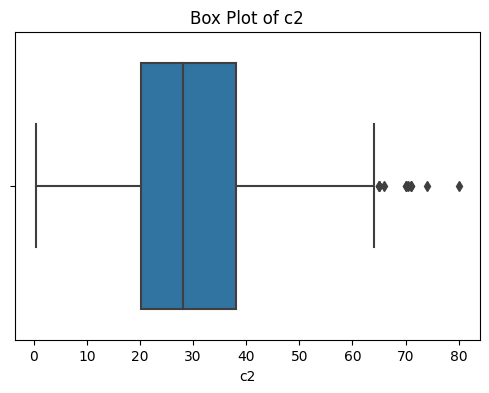

In [465]:
# Visualize the distribution of the first-in-order numerical features using a box plot.

#first_feature = numerical_features.columns[0]

first_feature = numerical_features.columns[0]

# Create a box plot for the first numerical feature
plt.figure(figsize=(6, 4))
sns.boxplot(x=numerical_features[first_feature])
plt.title(f"Box Plot of {first_feature}")
plt.show()

#### Categorical Features

In [466]:
# The Categorical Features are the ones that are not numerical.

categorical_features = df.select_dtypes(exclude=["int64", "float64"])
list_categorical_features = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
list_categorical_features.append("class_target")
#print(categorical_features)

'''
c1 represents gender, and is binary because it can only take two values: male/female
c5 is categorical and nominal, because it does not have a specific order.
c6 is categotical and nominal, because it does not have a specific order.
c7 is categorical and nominal, because it does not have a specific order.
c8 is categorical and ordinal. This cateogry can be ordered in a specific order: lower class --> middle class --> upper class
c9 is categorical and nominal, because it does not have a specific order.
class_target is categorical and binary. This cateogory takes either value 0 or 1.
'''

'\nc1 represents gender, and is binary because it can only take two values: male/female\nc5 is categorical and nominal, because it does not have a specific order.\nc6 is categotical and nominal, because it does not have a specific order.\nc7 is categorical and nominal, because it does not have a specific order.\nc8 is categorical and ordinal. This cateogry can be ordered in a specific order: lower class --> middle class --> upper class\nc9 is categorical and nominal, because it does not have a specific order.\nclass_target is categorical and binary. This cateogory takes either value 0 or 1.\n'

Binary Features: ['c1', 'class_target']
Nominal Features: ['c5', 'c6', 'c7', 'c8', 'c9']
Ordinal Features: []
Count of Categories for Each Categorical Feature:
 c1                2
c5              681
c6              147
c7                3
c8                3
c9              891
class_target      2
dtype: int64


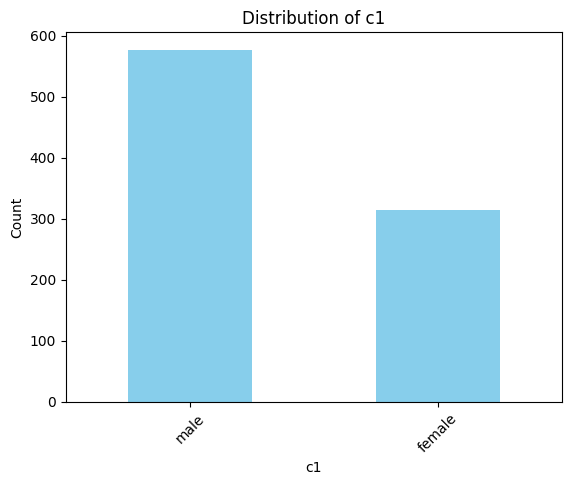

In [467]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and categorical_features is a list of your categorical columns
categorical_features = ['c1', 'c5', 'c6', "c7", "c8", "c9", "class_target"]  # Replace with your actual categorical features

# Identify the type of each categorical feature
binary_features = [col for col in categorical_features if df[col].nunique() == 2]
nominal_features = [col for col in categorical_features if df[col].nunique() > 2 and not df[col].dtype.name == 'category']
ordinal_features = [col for col in categorical_features if df[col].dtype.name == 'category']

print("Binary Features:", binary_features)
print("Nominal Features:", nominal_features)
print("Ordinal Features:", ordinal_features)

# Summarize the count of categories for all categorical features
category_counts = df[categorical_features].nunique()
print("Count of Categories for Each Categorical Feature:\n", category_counts)

# Visualize the distribution of the first-in-order categorical feature using bar plots
first_categorical_feature = categorical_features[0]
df[first_categorical_feature].value_counts().plot(kind='bar', color='skyblue')

plt.title(f'Distribution of {first_categorical_feature}')
plt.xlabel(first_categorical_feature)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Q3: Correlation Analysis

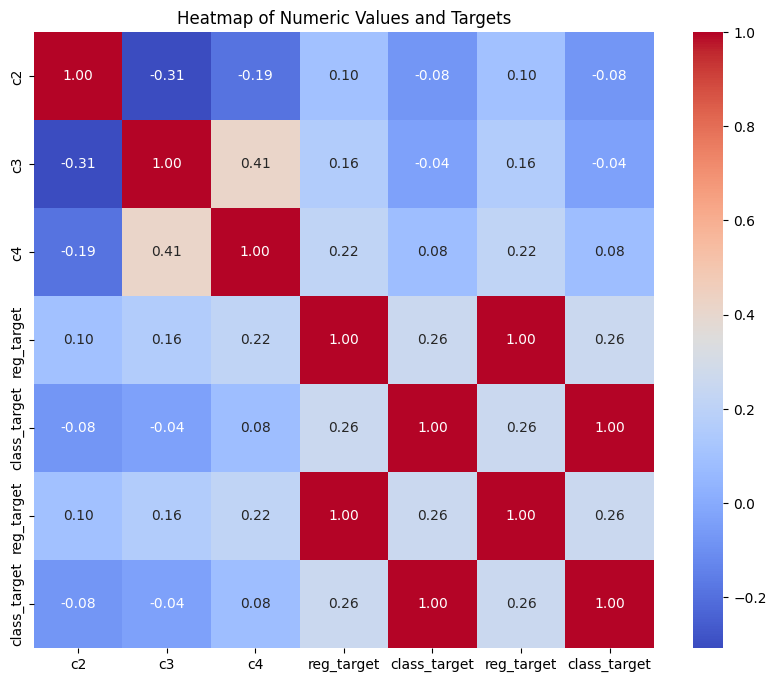

In [ ]:
### Need to fix perfect correlation problem between identical features.

#additional_features = df[["reg_target", "class_target"]]

# Concatenate the numerical features with the additional features
correlation_features = pd.concat([numerical_features], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Heatmap of Numeric Values and Targets")
plt.show()

In [ ]:
#### There is somethig wrong here

# Highlighting strong or weak correlations.

strong_threshold = 0.8
weak_threshold = -0.8

# Identify strong correlations
strong_correlations = correlation_matrix[(correlation_matrix.abs() > strong_threshold) & (correlation_matrix.abs() < 1.0)]

# Identify weak correlations
weak_correlations = correlation_matrix[(correlation_matrix.abs() < weak_threshold) & (correlation_matrix.abs() > 0)]

# Extract pairs of features with strong correlations
strong_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                for i in range(len(correlation_matrix)) 
                for j in range(i+1, len(correlation_matrix)) 
                if abs(correlation_matrix.iloc[i, j]) > strong_threshold]

# Extract pairs of features with weak correlations
weak_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
              for i in range(len(correlation_matrix)) 
              for j in range(i+1, len(correlation_matrix)) 
              if 0 < abs(correlation_matrix.iloc[i, j]) < weak_threshold]

print("Pairs of Features with Strong Correlations:", strong_pairs)
print("Pairs of Features with Weak Correlations:", weak_pairs)

Pairs of Features with Strong Correlations: [('reg_target', 'reg_target'), ('class_target', 'class_target')]
Pairs of Features with Weak Correlations: []
